# Build a Face Recognition System using eigen faces approach


## Steps to achieve the same

1. Collecting the images of 10-20 people. We want to collect atleast 15 images of each person and divide them into 75-25 ratio for testing and training respectively.
2. Install and use OpenCV for reading/writing images and also for detecting all the faces and converting them to grayscale.
3. We want to detect and locate the faces in our dataset and store them for future reference. (we're using Haarcascase face detector to do the same)
4. After detecting the faces, we want to extract those cropped faces and store that in the form of a numpy array.
5. Using the extracted cropped faces as our data for PCA and obtaining a 5-dimensional representation for each image. Also, we want to extract gray faces for test images using the same approach we've followed above and do PCA to get 5-d representation of each image.
6. Now, We've to do 1-NN classification for test and train data to perform face recognition.

---

## Plotting Function for subplot for various plots

In [1]:
def plot_portraits(images, titles, h, w, n_row, n_col):
    plt.figure(figsize=(2.2 * n_col, 2.2 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.50)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap="gray")
        plt.title(titles[i], color="black")
        plt.xticks(())
        plt.yticks(())

# Preprocessing our train data to obtain gray cropped faces of all the dataset

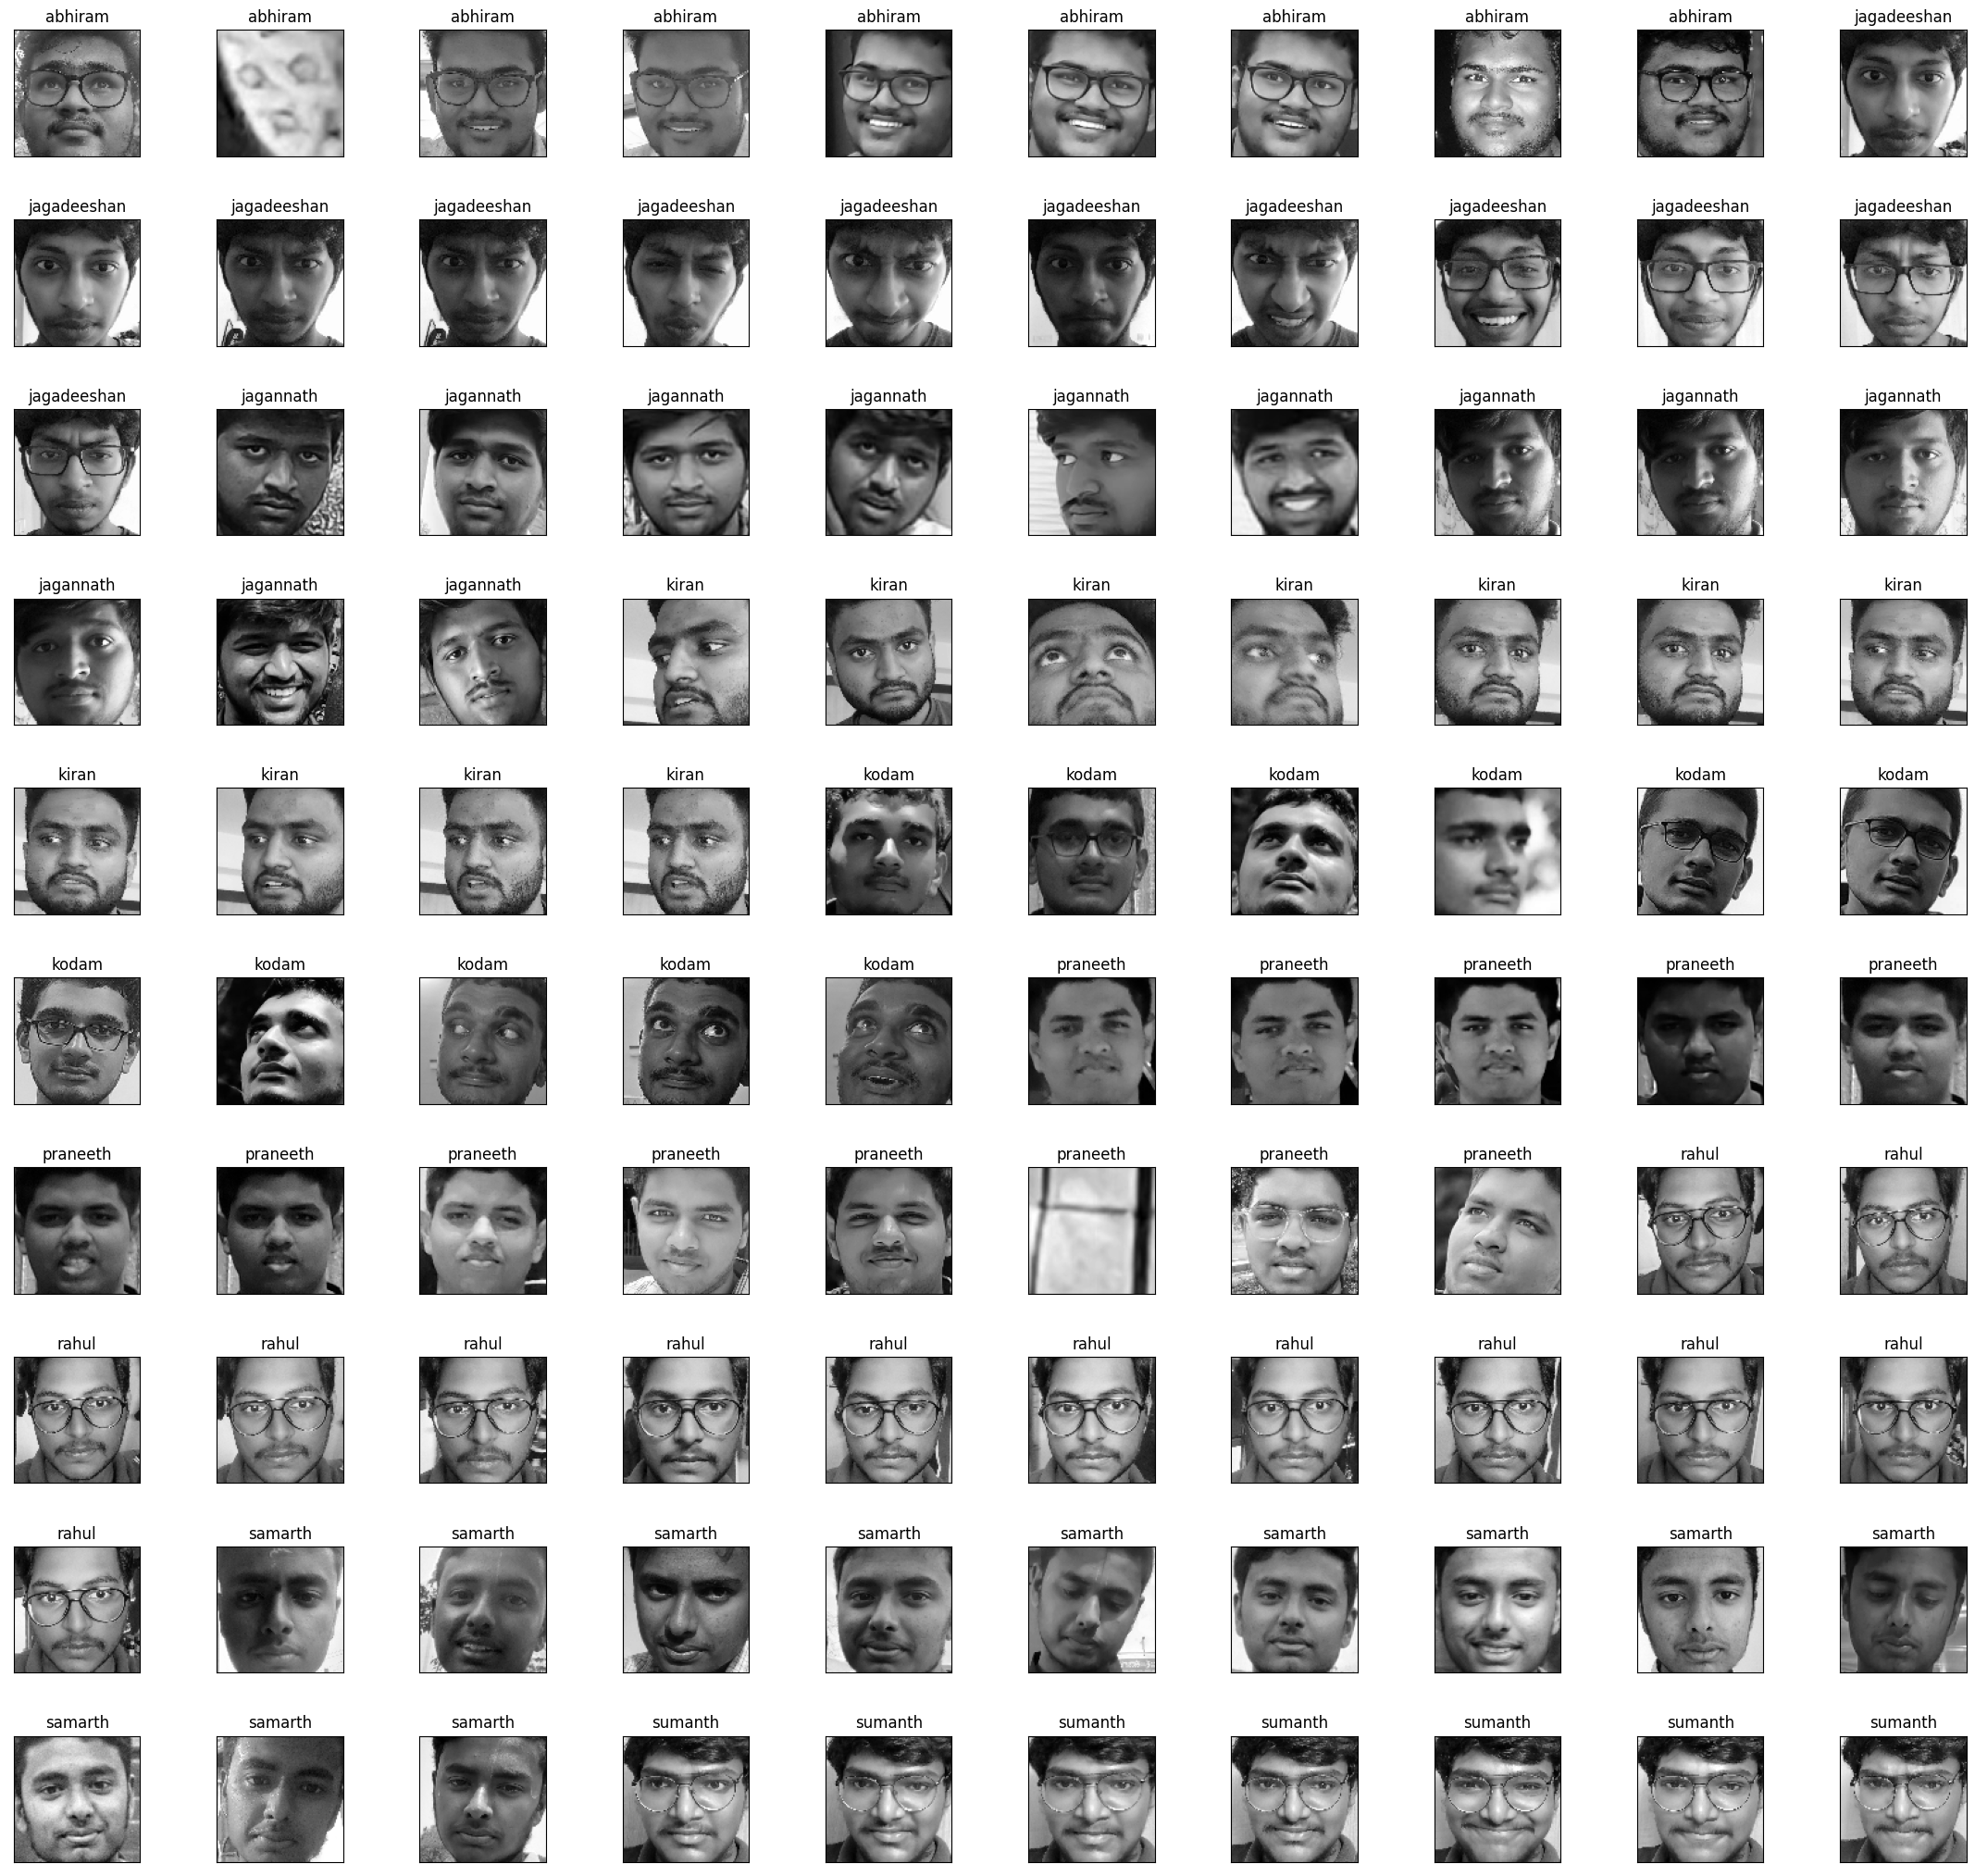

In [2]:
# Importing all our modules
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np

# Constant variables
trainAddr = "./dataset/train/*/*.jpg"
trainStore = "./dataset/train-cropped/"

# Faces array which stores the data of all the faces
facesArr = []
facesMatrix = []

# Function to extract all the images from the dataset
def trainPreprocess(fetchAddr,storeAddr):
    
    counter = 0
    label = glob.glob(fetchAddr)[0]
    
    # Traversing throught the images
    for imgAddress in glob.glob(fetchAddr):

        # Extracting the label of the image from folder name
        temp = imgAddress.split("\\")[1]
        
        # Checking if the label is changing
        if(temp==label):
            flag = 0
        else:
            flag = 1

        # Counter is initialized to 0 if label changes
        if(flag==1): 
            counter = 0

        label = temp    
        
        imgBGR = cv2.imread(imgAddress)
        tempArr = []

        imgRGB = cv2.cvtColor(imgBGR,cv2.COLOR_BGR2RGB)

        # Converting those images from BGR scale to grayscale
        test_image_gray = cv2.cvtColor(imgRGB,cv2.COLOR_BGR2GRAY)

        face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_alt.xml')
        faces=face_cascade.detectMultiScale(test_image_gray,scaleFactor=1.05,minNeighbors=9)

        # Ignore cases where the  
        if(len(faces)==0): 
            continue

        # Finding the biggest cropped face area patch
        biggestArea = max(faces[:,2]) * max(faces[:,3])
        for x,y,w,h in faces:
            
            # Extracting the largest matched patch of the image 
            if (biggestArea == w*h):
                counter += 1

                #display the cropped image
                crop_img=imgRGB[y:y+h,x:x+w]
                crop_img = cv2.resize(crop_img,(100,100))
                crop_img = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
                tempArr.append(crop_img)
                
                # Writing down the cropped gray faces
                cv2.imwrite(("%s%s-%d.jpg" % (storeAddr,label,counter)),crop_img)
        tempArr = np.array(tempArr)
        
        # Adding the face label and face cropped image to the faces array
        facesMatrix.append(list(tempArr.flatten()))
        facesArr.append(list([label,tempArr]))
        
# Calling the extracter function
trainPreprocess(trainAddr,trainStore)


# Extracting labels into an array
labelArr = []
for face in facesArr:
    labelArr.append(face[0])


facesMatrix = np.array(facesMatrix)
# Plotting top 100 faces from the above facesMatrix
plot_portraits(facesMatrix[:100], labelArr[:100], 100, 100, 10,10)

## Finding the Eigen Vector and Eigen Values

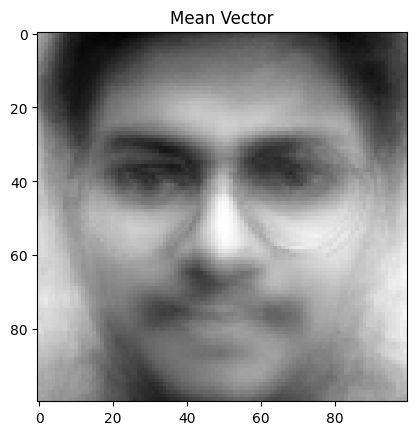

In [3]:
from numpy import linalg as LA

# Normalized matrix
normalizedMatrix = []

# Finding the matrix representation of the above array
facesMatrix = np.array(facesMatrix)

meanArr = np.mean(facesMatrix, axis = 0)

# Forming the normalized matrix
for matrixRow in facesMatrix:
    normalizedMatrix.append(np.subtract(matrixRow,meanArr))
    
normalizedMatrix = np.array(normalizedMatrix)
covariance = np.dot(facesMatrix,facesMatrix.T)
eigenValue, eigenVector = LA.eig(covariance)

# Plotting the mean vector
image = np.reshape(meanArr,(100,100))

plt.imshow(image,cmap='gray')
plt.title("Mean Vector")
plt.show()

## Finding the eigen faces for the above matrix data

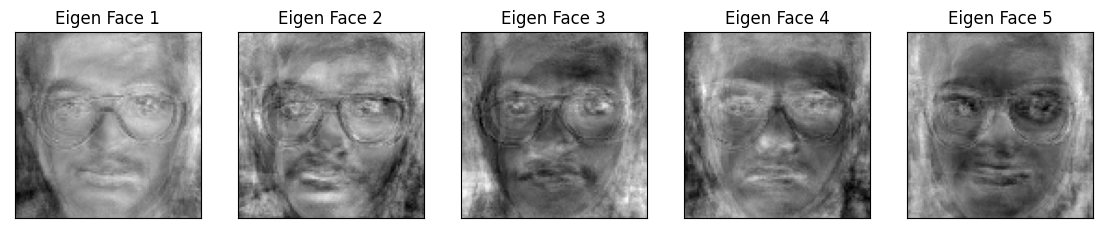

In [4]:
# Finding all the Eigen Faces
topVectorPair = []
topVectors = []
labels = []
tempCount = 0
count = 0

for i in eigenValue:
    topVectorPair.append([i,eigenVector[count,:]])
    count += 1
    
# Convert it to numpy array
list.sort(topVectorPair,reverse=True)
topVectorPair = np.array(topVectorPair,dtype=object)

topVectorPair = topVectorPair[0:5,:]

for row in topVectorPair:
    topVectors.append(row[1])
topVectors = np.array(topVectors)
    
# print(topVectors, topVectors.shape)

eigenFaces = topVectors.dot(normalizedMatrix).real

count = 1
for face in eigenFaces:
    face = np.add(face,meanArr)
    face = np.reshape(face,(100,100))
    labels.append("Eigen Face %d" % count)
    count+=1
    
plot_portraits(eigenFaces, labels, 100, 100, 1, 5)

### Extracting 5-dimension feature vector for train data

In [5]:
transformedMatrix = eigenFaces.dot(normalizedMatrix.T).real.T

print(f"\nOriginal dimension of the train data {facesMatrix.shape}")
print(f"Transformed the train data into dimension {transformedMatrix.shape}")


Original dimension of the train data (118, 10000)
Transformed the train data into dimension (118, 5)


---

## Extracting 5-dimension feature vector for the test data

### Extracting all images from test data

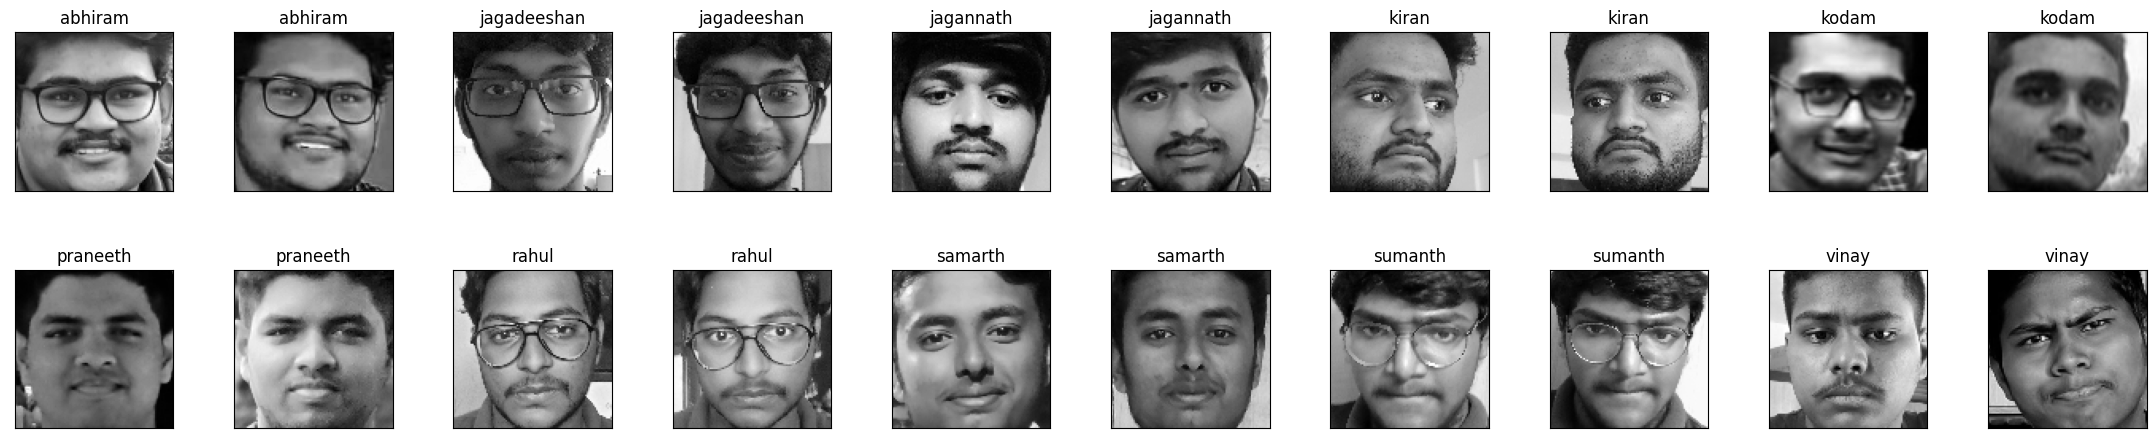

In [12]:
# Constant variables
testAddr = "./dataset/test/*/*.jpg"
testStore = "./dataset/test-cropped/"

# Faces array which stores the data of all the faces
testfacesArr = []
testfacesMatrix = []

# Function to extract all the images from the dataset
def trainPreprocess(fetchAddr,storeAddr):
    
    counter = 0
    label = glob.glob(fetchAddr)[0]
    
    # Traversing throught the images
    for imgAddress in glob.glob(fetchAddr):

        # Extracting the label of the image from folder name
        temp = imgAddress.split("\\")[1]
        
        # Checking if the label is changing
        if(temp==label):
            flag = 0
        else:
            flag = 1

        # Counter is initialized to 0 if label changes
        if(flag==1): 
            counter = 0

        label = temp    
        
        imgBGR = cv2.imread(imgAddress)
        tempArr = []

        imgRGB = cv2.cvtColor(imgBGR,cv2.COLOR_BGR2RGB)

        # Converting those images from BGR scale to grayscale
        test_image_gray = cv2.cvtColor(imgRGB,cv2.COLOR_BGR2GRAY)

        face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_alt.xml')
        faces=face_cascade.detectMultiScale(test_image_gray,scaleFactor=1.05,minNeighbors=9)

        # Ignore cases where the  
        if(len(faces)==0): 
            continue

        # Finding the biggest cropped face area patch
        biggestArea = max(faces[:,2]) * max(faces[:,3])
        for x,y,w,h in faces:
            
            # Extracting the largest matched patch of the image 
            if (biggestArea == w*h):
                counter += 1

                #display the cropped image
                crop_img=imgRGB[y:y+h,x:x+w]
                crop_img = cv2.resize(crop_img,(100,100))
                crop_img = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
                tempArr.append(crop_img)
                
                # Writing down the cropped gray faces
                cv2.imwrite(("%s%s-%d.jpg" % (storeAddr,label,counter)),crop_img)
                
        tempArr = np.array(tempArr)
        
        # Adding the face label and face cropped image to the faces array
        testfacesMatrix.append(list(tempArr.flatten()))
        testfacesArr.append(list([label,tempArr]))
        
# Calling the extracter function
trainPreprocess(testAddr,testStore)


# Extracting test labels into an array
testLabels = []
for face in testfacesArr:
    testLabels.append(face[0])
    
testfacesMatrix = np.array(testfacesMatrix)
# Plotting top 100 faces from the above facesMatrix
plot_portraits(testfacesMatrix[:20], testLabels[:20], 100, 100, 2,10)

### Normalising the above test images array

In [8]:
testNormalizedMatrix = []

# Forming the test normalized matrix
for matrixRow in testfacesMatrix:
    testNormalizedMatrix.append(np.subtract(matrixRow,meanArr))

testNormalizedMatrix = np.array(testNormalizedMatrix)
testTransformedMatrix = eigenFaces.dot(testNormalizedMatrix.T).real.T

testfacesMatrix = np.array(testfacesMatrix)
print(f"\nOriginal dimension of the test data {testfacesMatrix.shape}")
print(f"Transformed the test data into dimension {testTransformedMatrix.shape}")


Original dimension of the test data (20, 10000)
Transformed the test data into dimension (20, 5)


## K-NN Classifier based recognition system

Accuracy score using inbuilt K-NN: 40.0


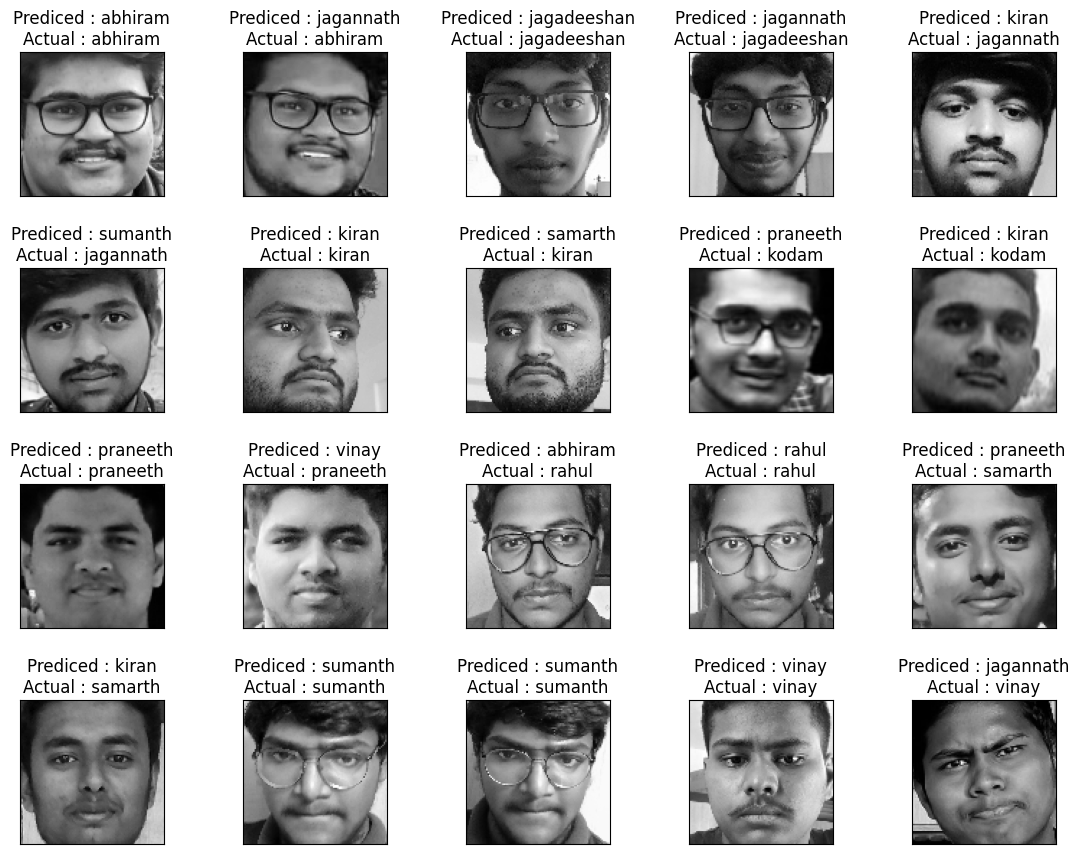

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(transformedMatrix, labelArr)

testfacesMatrix = np.array(testfacesMatrix)


testLabelPredict = knn.predict(testTransformedMatrix)

titles = []
for i in range(len(testLabels)):
    titles.append("Prediced : %s\nActual : %s" % (testLabelPredict[i],testLabels[i]))
    
plot_portraits(testfacesMatrix, titles, 100, 100, 4, 5)


score = accuracy_score(testLabels, testLabelPredict)
print(f"Accuracy score using inbuilt K-NN: {score*100}")